# Examen 2
## Cours A59 - apprentissage par renforcement

-----

**Objectif**

Nous allons utiliser un réseau DQN mais sur un environnement déjà résolu avec des algorithmes classiques.<br>

C'est l'opportunité de tester quelques hypothèses sans pénaliser ceux d'entre vous qui ont des machines moins puissantes.<br>

Vous aurez besoin des bibliothèques suivantes :<br>
 tensorflow<br>
 gymnasium<br>
 numpy<br>
 matplotlib<br>

 
(c) Fabrice Mulotti


In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import numpy as np
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt
import tensorflow as tf
print(f"Tensorflow version {tf.__version__}")
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
# Selon votre version de keras. Si keras 2.x :
from tensorflow.keras.optimizers import Adam 
# si keras 3.x :
from tensorflow.keras.optimizers import Adam 


import time
# tf.compat.v1.disable_eager_execution()

2024-11-03 10:54:12.127250: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 10:54:12.127834: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-03 10:54:12.129947: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-03 10:54:12.136142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730649252.146534 1271340 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730649252.14

Tensorflow version 2.18.0


In [3]:
gym.__version__

'1.0.0'

---
## Définition de l'environnement

Lien vers les informations sur l'environnement : __[Frozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)__


In [4]:
ENV_NAME = "FrozenLake-v1"

env = gym.make(ENV_NAME,is_slippery=False)
np.random.seed(100)
env.reset(seed=100)
nb_actions = env.action_space.n # Nombre d'action
nb_obs = env.observation_space.n # nombre de position dans notre environnement
print(f"Nombre d actions : {nb_actions}, Dimension de l env : {nb_obs}")

Nombre d actions : 4, Dimension de l env : 16


### Remarques sur l'environnement

4 actions possibles :<br>
    Gauche, bas, droite, haut
    
Observation :<br>
    Valeurs discrètes (0 à 15)

## Compréhension de l'environnement
 la suite du TP il va être important de bien comprendre le principe des récompenses.

La transition vers **l'objectif** rapporte combien ?

La transition vers **un puit** rapporte combien ?

La transition vers une **case gelée** (c'est à dire toutes les autres cases) rapporte combien ?

Donc un épisode avec echec aura une récompense **totale** (G avec gamma=1) de combien ?

Et donc un épisode réussi aura une récompense **totale** (G avec gamma=1) de combien ?

Quelles sont donc les deux seules récompenses possibles cumulées pour un épisode ?

---
## Représentation de l'environnement

Nous sommes sur une matrice 4x4.

Il existe plusieurs facons de représentation chaque état.

Cela pourrait être par exemple, une seule valeur d'entrée, un entier entre 0 et 15.

Nous allons opter pour une approche qui montre plus d'efficacité, nous allons représenter le statut par un numpy de 1 dimension de grandeur 16.
Toutes les valeurs seront à zéro, sauf l'indice correspondant à la position du joueur qui sera à 1.

Exemple :
Si nous déclarerions un tableau numpy S tel que S=np.zeros((16))
Alors si le joueur est en position 3 => S[3]=1 

S = [ 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 ]

---
## Réseau de neurones


Quel type de réseau de neurones allons nous utiliser ?

Pouvons donner une proposition de description pour ce réseaux (nombre de neurones pour les couches d'entrée, cachée(s) et de sortie ?
Il y a plusieurs réponses possibles.

## Fonctions utiles (rien à coder ici)

In [5]:
# Classe pour notre algorithme DQN
class DQN:
    def __init__(self, obs_size, action_size, gamma, learning_rate,layer1=16):
        # Objet : initialisation de la classe
        # Paramètres en entrée
        #     Nombre de paramètres pour décrire l'état
        #     Nombre d'actions
        #.    Paramètre gamma : dépréciation futur
        #     learning rate
        
        # dimension des états
        self.obs_size = obs_size
        
        # nombre d'actions
        self.action_size = action_size
        
        # gamma : dépréciation du futur
        self.gamma = gamma
        
        # learning rate
        self.learning_rate = learning_rate
        
        # autres paramètres
        self.update_freq = 100 # fréquence de copie des poids (1000)
        
        # autres structures
        self.replay_buffer = deque(maxlen=5000) # enregistrements des résultats
        
        # Modèle de réseaux de neurones
        self.main_network = self.build_model(layer1)
        self.target_network = self.build_model(layer1)
        
        # recopie des poids pour avoir des réseaux à l'identique
        self.target_network.set_weights(self.main_network.get_weights())
        
              
    def build_model(self,layer1):
        # input : size of the 2 layers
        # output : model of neural network
        model = Sequential()
        model.add(Dense(layer1,input_shape=(self.obs_size,),activation='relu'))
        model.add(Dense(self.action_size))
        model.add(Activation('linear'))
        # si keras 2.x
        # model.compile(loss='mse',optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=self.learning_rate))
        # si keras 3.x
        model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),jit_compile=True)

        return model
matplotlib
    def store_transition(self,state,action,reward,next_state,done):
        # input : 
        # output : nothing
        self.replay_buffer.append((state,action,reward,next_state,done))
        
    def policy(self, state, epsilon):
        # Policy : return action regarding the state according to the policy
        r = np.random.uniform()
        if r < epsilon:
            action = np.random.randint(self.action_size)
        else:
            actions = self.main_network.predict_on_batch(state)
            action = np.argmax(actions[0])
 
        return action

    @tf.function
    def _train_step(self, states, Q_values):    
            self.main_network.fit(states,Q_values,epochs=1,verbose=0)
        
    def train_model_fast(self,batch_size):
         # Implémentation parallèle
        minibatch = random.sample(self.replay_buffer,batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        # on supprime l'axe y (=1) de x,y,z
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        # 1-done : si done on ne prend en compte que reward
        targets = rewards + self.gamma*(np.amax(self.target_network.predict_on_batch(next_states), axis=1))*(1-dones) 
        
        targets_full = self.target_network.predict_on_batch(states) 
        ind = np.array([i for i in range(batch_size)])
        targets_full[[ind], [actions]] = targets      
        
        #self.main_network.fit(states, targets_full, epochs=1, verbose=0)
        self._train_step(states,targets_full)
        
    def update_weights(self):matplotlib
        self.target_network.set_weights(self.main_network.get_weights())
        

---

## Variante DQN (3 pts)

Pouvez vous décrire une variante de DQN et son intêret en quelques mots ? 

#

In [6]:
        # selection de l'action en S' selon le réseau main
        next_actions=np.argmax(self.main_network.predict_on_batch(next_states),axis=1)
        
        # Mettre à jour Q[s,a] avec Q'[S',a selon Q]
        targets = rewards + self.gamma*(self.target_network.predict_on_batch(next_states)[[i for i in range(batch_size)],next_actions])*(1-dones)
        
        # on récupère Q connu avant mise à jour
        targets_full = self.target_network.predict(states,verbose=0) 

        # mise à jour de Q
        ind = np.array([i for i in range(batch_size)])
        targets_full[[ind], [actions]] = targets

NameError: name 'self' is not defined

Note : la taille des épisodes est trop petite pour mesurer le bénéfice de DDQN

In [7]:
# transformation des données pour compatibilité avec l'alimentation du réseau de neurones (1,s)`
def trans_state(s):
    state=np.zeros((nb_obs ))
    state[s]=1
    return  np.reshape(state, [1, nb_obs ])

In [8]:
trans_state(5)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
 assert (trans_state(5) == np.array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])).all() == True

----
## Lancons la simulation

In [10]:
num_episodes = 1000
batch_size = 10 # K
gamma=0.99 

# variation du epsilon de notre politique e-greedy
epsilon_max=1.00
epsilon_min=0.10
epsilon_decay=(epsilon_max-epsilon_min)/(num_episodes/2)

learning_rate=0.001 # 0.001

In [11]:
dqn = DQN(nb_obs,nb_actions,gamma,learning_rate,64)

/home/jupiter/data/dev/tmp2/to_poseidon/rlexam2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1730649267.101727 1271340 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
start_time=time.time()
last_time=start_timematplotlib
train_time=0
time_step = 0  # comptage du nombre total de mouvement
histoReturn=[] # pour graphique sur historique récompense
epsilon=epsilon_max

for i in range(num_episodes):
    # somme de la récompense total pour une cycle
    Return = 0
    
    # reset env et conversion state
    state = trans_state(env.reset()[0])
    done=False
    truncated=False
    episode_length=0
    while not(done or truncated):
    
        time_step += 1
        episode_length+=1

        # copie des poids du réseau d'entrainement vers le réseau cible selon la fréquence choisie
        if time_step % dqn.update_freq == 0:
            dqn.update_weights()
        
        # sélection d'une action selon notre politique
        action = dqn.policy(state,epsilon)

        # jouer l'action
        next_state, reward, done, truncated , _ = env.step(action)
        next_state=trans_state(next_state) # reformatage
        if truncated:
            done=True 
      
        # enregistrement pour replay
        dqn.store_transition(state, action, reward, next_state, done)
        
        # et shift d'état
        state = next_state
        
        # cumul du retour G
        Return += reward

        if episode_length==100: # nous limitons les épisodes à 100 mouvements
            truncated=True
            
        # Done ?
        if done or truncated:    
            # on décremmente epsilon
            epsilon -= epsilon_decay
            epsilon = max(epsilon_min, epsilon)
            histoReturn.append(Return)

            # affichage du résultat du cyle
            if (i>0 and i % 100 ==0) or i == (num_episodes-1):
                print(f"Episode {i}, Taux de victoire {np.round(np.sum(histoReturn)/(i+1)*100,0)}%,\
                 epsilon {np.round(epsilon,2)}, durée {int(time.time()-last_time)}, training time {int(train_time)}")
                last_time=time.time()
                train_time=0
            break
            
        # à partir de + batch-size on entraine le reseau
        train_start=time.time()
        if len(dqn.replay_buffer) > batch_size: #  and i%10 == 0:
            dqn.train_model_fast(batch_size)
        train_end=time.time()
        train_time += train_end-train_start
print("--------------------------------------------------")
print(f"Durée de l'entrainement = {np.round(time.time()-start_time,0)} secondes")

I0000 00:00:1730649268.192461 1271424 service.cc:148] XLA service 0x7f0200006970 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730649268.192499 1271424 service.cc:156]   StreamExecutor device (0): Host, Default Version
2024-11-03 10:54:28.197989: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730649268.214991 1271424 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode 100, Taux de victoire 5.0%,                 epsilon 0.82, durée 10, training time 9
Episode 200, Taux de victoire 9.0%,                 epsilon 0.64, durée 6, training time 6
Episode 300, Taux de victoire 17.0%,                 epsilon 0.46, durée 7, training time 7
Episode 400, Taux de victoire 26.0%,                 epsilon 0.28, durée 7, training time 6
Episode 500, Taux de victoire 36.0%,                 epsilon 0.1, durée 6, training time 6
Episode 600, Taux de victoire 44.0%,                 epsilon 0.1, durée 6, training time 5
Episode 700, Taux de victoire 50.0%,                 epsilon 0.1, durée 6, training time 5
Episode 800, Taux de victoire 55.0%,                 epsilon 0.1, durée 6, training time 5
Episode 900, Taux de victoire 59.0%,                 epsilon 0.1, durée 6, training time 6
Episode 999, Taux de victoire 62.0%,                 epsilon 0.1, durée 5, training time 5
--------------------------------------------------
Durée de l'entrainement = 69.0 secon

Vous devriez arriver à un taux de réussite de près de 60% à la fin de l'entrainement.

In [13]:
test_decision=np.zeros((nb_obs))
test_decision[0] = 1
test_decision.shape

(16,)

---

Que recommande notre classe dqn en position 0 et 14 ?

In [14]:
np.argmax(dqn.main_network.predict(trans_state(0)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


np.int64(1)

In [15]:
np.argmax(dqn.main_network.predict(trans_state(14)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


np.int64(2)

Est ce correct ?

---
# Comparons avec Q-Learning Classique (rien à coder)

In [16]:
def politique_egreedy(env,Q,s,epsilon):
    # en entrée : env=environnement, Q fonctions action valeur, s = état courant, epsilon= pour espilon-greedy
    r=np.random.uniform()
    if r<epsilon:
        return(env.action_space.sample())
    else:
        return(np.argmax(Q[s,]))

In [17]:
# Nombre d'essai
max_iter=50000
alpha=0.50   # learning rate
gamma=0.99   # part du futur
epsilon=1.0 # part de hasard
epsilon_min=0.10
epsilon_decay=(epsilon-epsilon_min)/(max_iter/2)
Q=np.zeros((env.observation_space.n,env.action_space.n))
matplotlib
# liste des valeurs pour créer un graphique 
histoReturn=[]
histoLongueurEpisode=[]
start_time=time.time()
for i in range(max_iter):
    S=env.reset()[0]

    done=False
    truncated=False
    cumulR=0 # cumul des récompenses par épisode
    cumulA=0 # cumul du nombre d'action = longueur des épisodes
    
    while not (done or truncated):
        A=politique_egreedy(env,Q,S,epsilon)
        S_ , R, done, truncated, _ = env.step(A)
        A_=politique_egreedy(env,Q,S_,0) # ## epsilon = 0 => pas de hasard = greedy
        
        Q[S,A] = Q[S,A] + alpha*(R+gamma*Q[S_,A_]-Q[S,A])

        cumulR+=R
        cumulA+=1
        S=S_

    epsilon -= epsilon_decay
    epsilon = max(epsilon, epsilon_min)
    
    histoReturn.append(cumulR)
    histoLongueurEpisode.append(cumulA)
 
    if i % (max_iter/10) ==0 or i == (max_iter-1):
      print(f"Episode {i}, Taux de victoire {np.round(np.sum(histoReturn)/(i+1)*100,0)}%,\
      epsilon {np.round(epsilon,2)}")

print(f"Durée de l'entrainement = {np.round(time.time()-start_time,0)} secondes")

Episode 0, Taux de victoire 0.0%,      epsilon 1.0
Episode 5000, Taux de victoire 4.0%,      epsilon 0.82
Episode 10000, Taux de victoire 10.0%,      epsilon 0.64
Episode 15000, Taux de victoire 19.0%,      epsilon 0.46
Episode 20000, Taux de victoire 28.0%,      epsilon 0.28
Episode 25000, Taux de victoire 38.0%,      epsilon 0.1
Episode 30000, Taux de victoire 47.0%,      epsilon 0.1
Episode 35000, Taux de victoire 53.0%,      epsilon 0.1
Episode 40000, Taux de victoire 58.0%,      epsilon 0.1
Episode 45000, Taux de victoire 61.0%,      epsilon 0.1
Episode 49999, Taux de victoire 64.0%,      epsilon 0.1
Durée de l'entrainement = 3.0 secondes


Vous devriez arriver à un taux autour de 60%

/tmp/ipykernel_1271340/156184330.py:9: RuntimeWarning: invalid value encountered in divide
  ax1.plot(np.cumsum(histoReturn)/np.arange(max_iter)*100)
/tmp/ipykernel_1271340/156184330.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


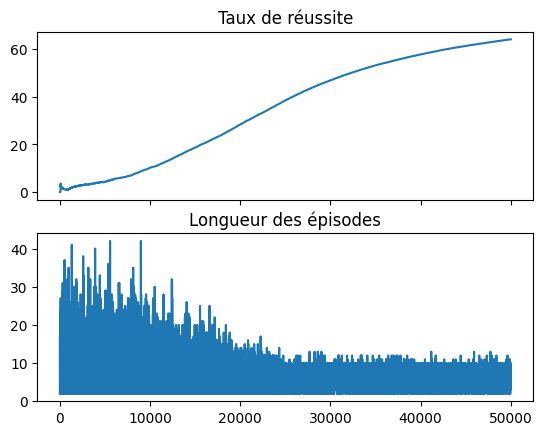

In [18]:
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True)

ax1.set_title("Taux de réussite")
ax2.set_title("Longueur des épisodes")

# fig.title("Récompenses cumulées par épisode")

ax2.plot(histoLongueurEpisode)
ax1.plot(np.cumsum(histoReturn)/np.arange(max_iter)*100)
fig.show()

---
# Comparaison

Nous venons de tester un algortihme avec réseau de neurones et un algoritgme classique.

En comparant le temps de traitement, puis le nombre d'épisode, quelles conclusions pouvez vous tirer ?

---
## DQN vs Policy Gradient ( 5pts)

Aurions nous pu utiliser policy gradient pour résoudre cet environnement ?

Oui bien sur. Pas de différence.

Citer 3 différences entre les deux implémentations (DQN vs Policy Gradient) ?

DQN estime les Q[s,a], Policy gradient estime les probabilités d'actions<br>

DQN s'appui sur un replay buffer, PG sur un enregistrement des épisodes comme Monte Carlo.<br>

DQN nécessite deux RNs, Policy Gradient un seul.<br>

DQN ne peut traiter qu'un ensemble fini d'action, PG peut traiter des actions continues

---
# N'oubliez pas de m'envoyer le notebook par MIO !